# Fall 2022 Model A

In [58]:
from commonfunctions import *
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Q1

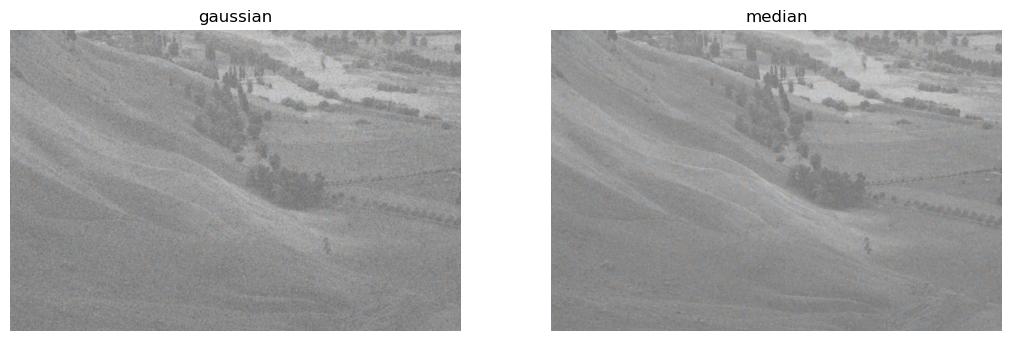

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


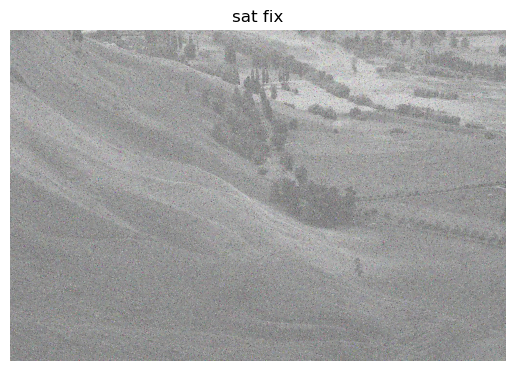

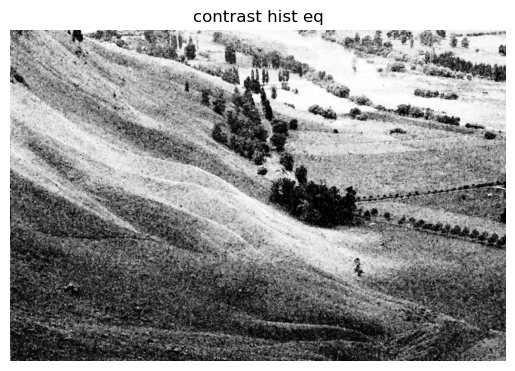

In [ ]:
img : np.ndarray = io.imread("Q1.jpg")
# problems: noise, contrast

median_noise_rem = median(img)
show_images([gaussian(img), median_noise_rem], ["gaussian", "median"])

def custom_hist(img, nbins=256):
    imgHist = np.zeros(256)
    for x in range(np.shape(img)[0]):
        for y in range(np.shape(img)[1]):
            imgHist[img[x, y]] += 1
    return imgHist

def getImageWithHist(img,ext=0,nbins=256):
    imgHist = custom_hist(img, nbins=nbins)
    Hc = 0
    shape = np.shape(img)
    NM = shape[0] * shape[1]
    for x in range(len(imgHist)):
        Hc += imgHist[x]
        imgHist[x] = (len(imgHist) -1 ) * Hc / NM
        
    img_copy = np.copy(img)
    for x in range(np.shape(img_copy)[0]):
        for y in range(np.shape(img_copy)[1]):
            img_copy[x, y] = imgHist[img_copy[x, y]]
    return img_copy

gray = (rgb2gray(median_noise_rem) * 255).astype("uint8")
show_images([getImageWithHist(gray)], ["contrast hist eq"])

## Q2

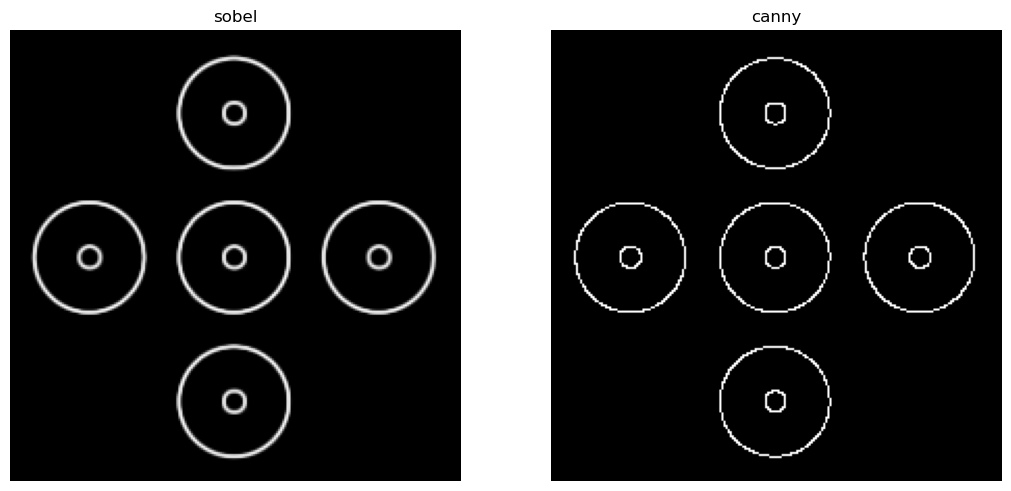

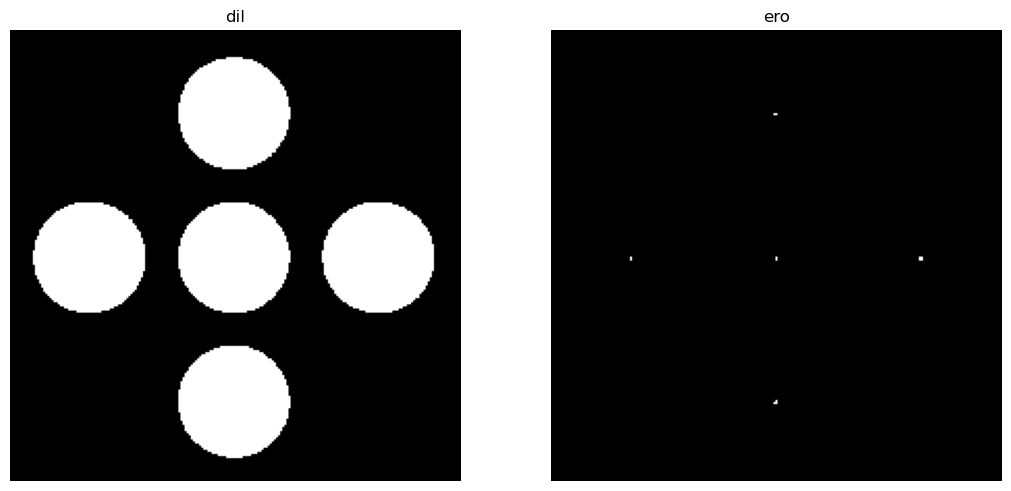

In [60]:
img : np.ndarray = io.imread("Q2.png")
show_images([sobel(img), canny(img, sigma=1, low_threshold=80, high_threshold=200)], ["sobel", "canny"])

se_dil = np.ones((1,1))
se_ero = np.ones((38,38))
dilated = binary_dilation(img, se_dil)
eroded = binary_erosion(dilated, se_ero)
show_images([dilated, eroded], ["dil", "ero"])

## Q3

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


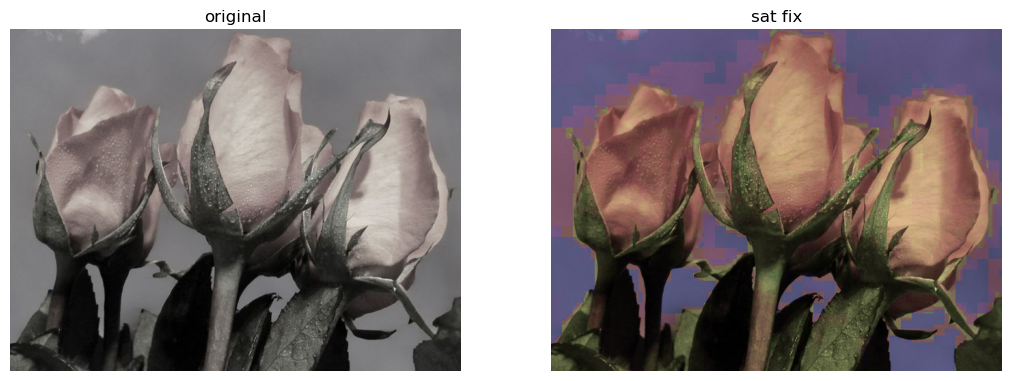

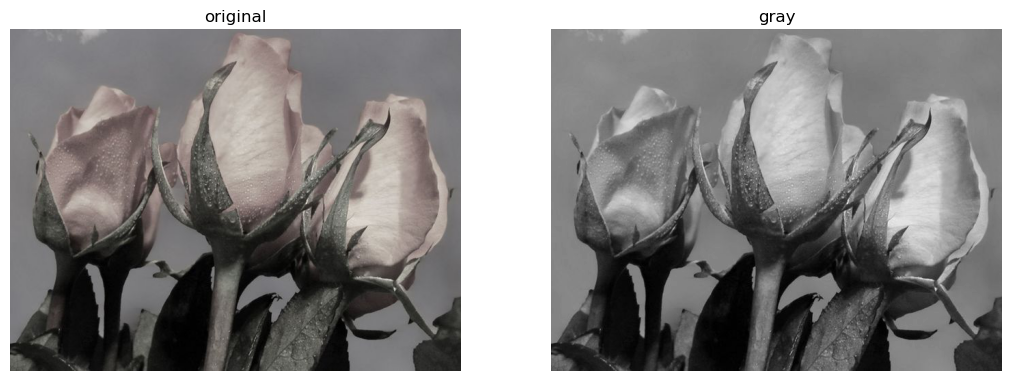

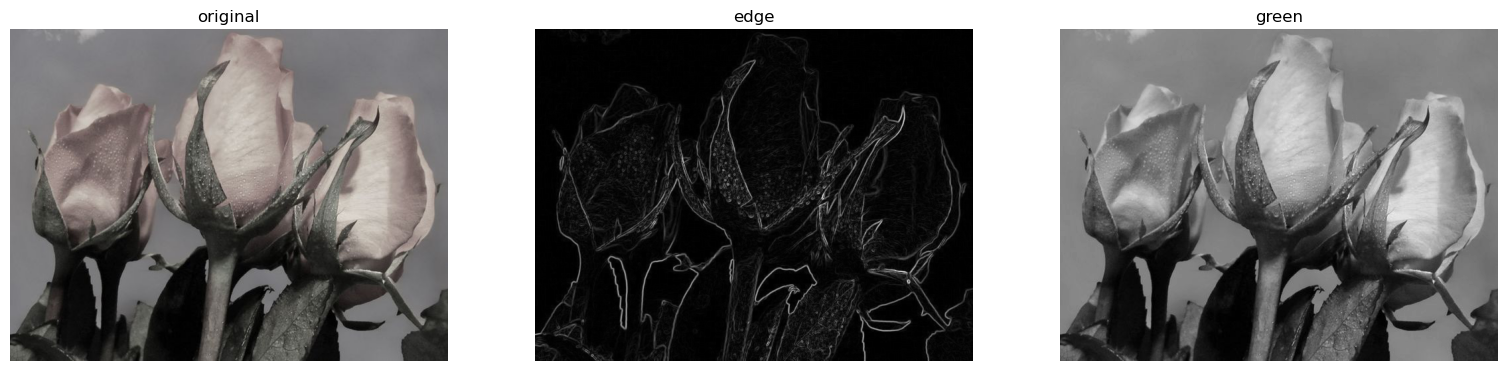

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


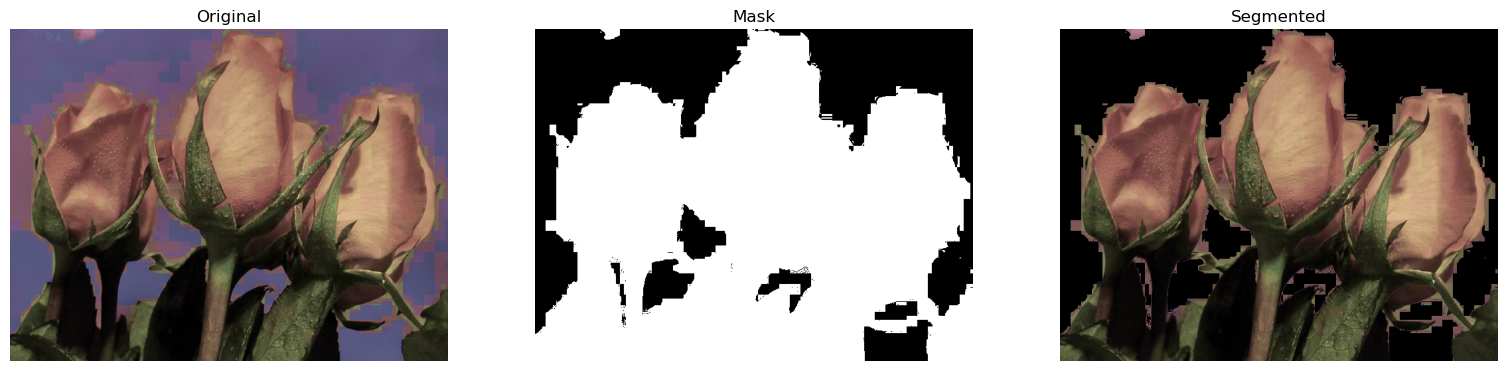

In [197]:
# fix sat
img: np.ndarray = io.imread("Q3.jpg")

hsv = rgb2hsv(img)
hsv[:, :, 1] += 0.3
fixed_sat = hsv2rgb(hsv)
show_images([img, fixed_sat], ["original", "sat fix"])

# isolate roses
gray = (rgb2gray(img) * 255).astype("uint8")
show_images([img, gray], ["original", "gray"])
show_images([img, sobel(gray), img[:, :, 1]], ["original", "edge", "green"])

from sklearn.cluster import KMeans

# Reshape image to (num_pixels, 3)
pixels = fixed_sat.reshape(-1, 3)

# Apply K-Means clustering
kmeans = KMeans(n_clusters=15, random_state=42).fit(pixels)
labels = kmeans.labels_.reshape(fixed_sat.shape[:2])

# Determine foreground cluster
foreground = (labels != 3) & (labels != 8) & (labels != 10)

# Apply mask
result = fixed_sat.copy()
result[~foreground] = 0

# Visualize
show_images([fixed_sat, foreground, result], ["Original", "Mask", "Segmented"])

[62870, 306607, 89670, 130991, 278162, 74655, 20404, 285351]


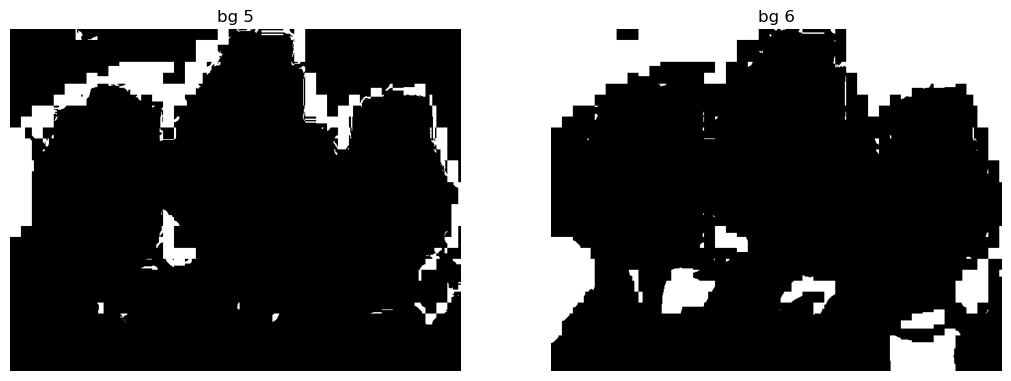

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


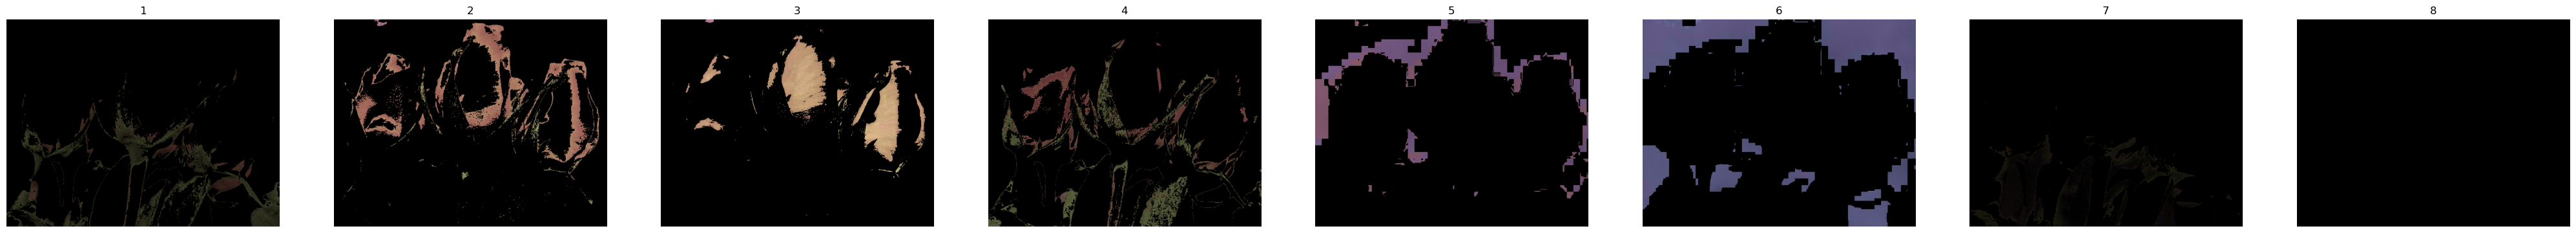

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


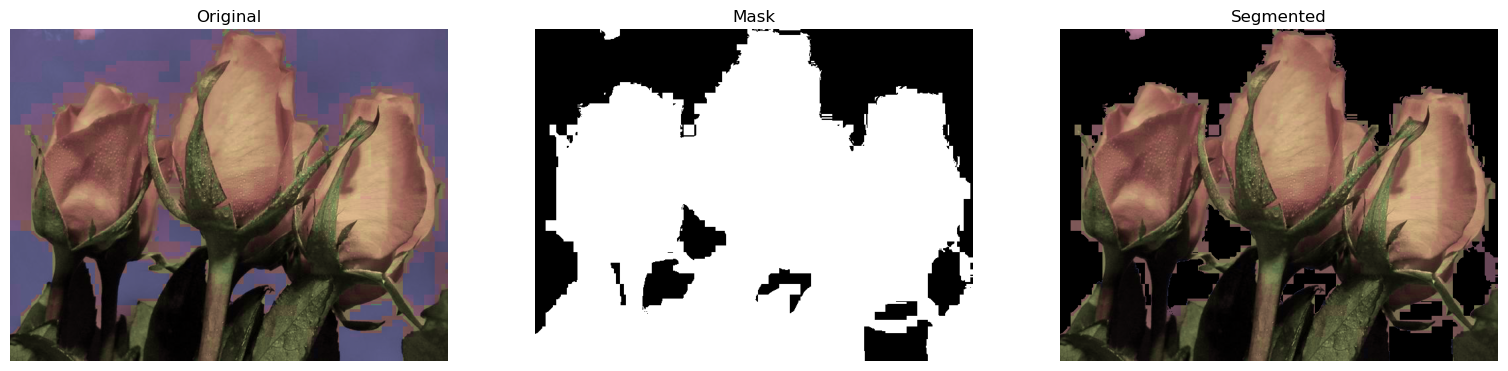

In [208]:
def kmeans(data, k, max_iters=100, tolerance=1e-4):

    # Randomly initialize centroids
    num_samples, num_features = data.shape
    # old: choice = np.random.choice(num_samples, k, replace=False)
    choice = [62870, 306607, 89670, 130991, 278162, 74655, 20404, 285351]
    centroids = data[choice]
    print(choice)

    for iteration in range(max_iters):
        # Step 1: Assign clusters
        distances = np.linalg.norm(
            data[:, np.newaxis] - centroids, axis=2
        )  # Compute distances to centroids
        labels = np.argmin(distances, axis=1)  # Assign to nearest centroid

        # Step 2: Update centroids
        new_centroids = np.array(
            [
                data[labels == i].mean(axis=0) if np.any(labels == i) else centroids[i]
                for i in range(k)
            ]
        )

        # Check for convergence
        if np.linalg.norm(new_centroids - centroids) < tolerance:
            break

        centroids = new_centroids

    return labels, centroids


pixels = fixed_sat.reshape(-1, 3)  # Flatten image to (num_pixels, 3)

k = 8
labels, centroids = kmeans(pixels, k)

# Reshape labels to the image's 2D shape
labels_img = labels.reshape(fixed_sat.shape[:2])

# Determine foreground cluster
results = []
selected_bg = []
selected_bg_idx= []
for i in range(1, k + 1):

    foreground = labels_img == i

    # Apply mask
    result = fixed_sat.copy()
    result[~foreground] = 0
    results.append(result)
    # isolate sky and pink area around roses
    if result[10, 2].any() != 0 or result[10, -2].any() != 0 or result[round(result.shape[0] / 2), 0].any() != 0:
        selected_bg.append(foreground)
        selected_bg_idx.append(f"bg {i}")

show_images(selected_bg, selected_bg_idx)

# Visualize
show_images(results, list(range(1, k + 1)))

result = fixed_sat.copy()
final_bg = selected_bg[0]
for bg in selected_bg:
    final_bg |= bg

result[final_bg] = 0
show_images([fixed_sat, ~final_bg, result], ["Original", "Mask", "Segmented"])